In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse as sps

import jlinops
import sampi

# Toy problem

In [2]:
ground_truth = jlinops.piecewise_constant_1d_test_problem()
n = len(ground_truth)
np.random.seed(0)
noise_stdev = 0.15
noise_var = noise_stdev**2
noisy_signal = ground_truth + noise_stdev*np.random.normal(size=n)
grid = np.arange(n)

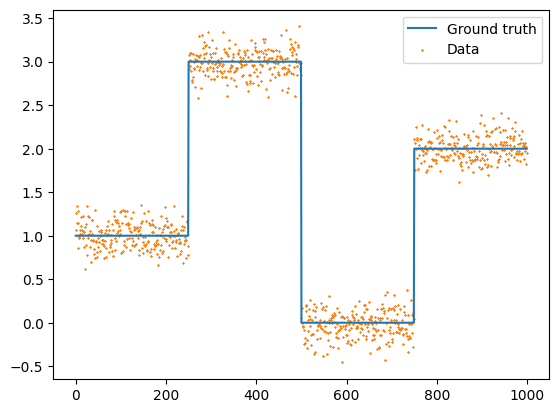

In [3]:
plt.plot(grid, ground_truth, label="Ground truth", color="C0")
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.legend()
plt.show()

In [4]:
# Define forward operator and regularization matrix
F = jlinops.IdentityOperator((n,n))
Rmat, Wmat = jlinops.first_order_derivative_1d(n, boundary="none")
W = jlinops.MatrixLinearOperator(Wmat)
R = jlinops.MatrixLinearOperator(Rmat)

In [5]:
hyperparams = {
}

_Rpinv = jlinops.MatrixLinearOperator(np.linalg.pinv(R.A.toarray()))
Rpinv_factory = lambda theta: _Rpinv @ jlinops.DiagonalOperator(np.sqrt(theta))

# def Rpinv_factory(theta):
#     Rtilde = jlinops.MatrixLinearOperator(sps.diags(1.0/np.sqrt(theta)) @ Rmat)
#     return jlinops.BandedCholeskyPinvOperator(Rtilde, delta=1e-8)

pdata = {
    "W": W,
    "Rpinv_factory": Rpinv_factory,
}

In [6]:
# Prior parameters
reg_lambda = 1e2
vartheta = 2/(reg_lambda**2)
hyperparams = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-2,
        "vartheta": vartheta,
    },
    "noise_var": {
        "r": -1.0,
        "beta": 1,
        "vartheta": 1e-4,
    }
}

# Create solver
solver = sampi.IASSolver(F, R, noisy_signal, hyperparams, noise_var=None, pdata=pdata)

In [7]:
data = solver.solve(max_iters=100, priorconditioning=True, early_stopping=False, warmstarting=True, eps=1e-3)

In [8]:
data["n_iters"]

100

In [9]:
data.keys()

dict_keys(['x', 'theta', 'n_cg_its_per_iteration', 'converged', 'obj_vals', 'noise_var', 'noise_vars', 'n_iters'])

In [10]:
print(np.sum(data["n_cg_its_per_iteration"]))

146


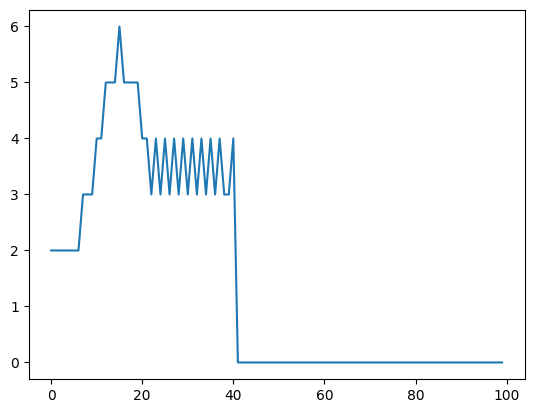

In [11]:
plt.plot(data["n_cg_its_per_iteration"])
plt.show()

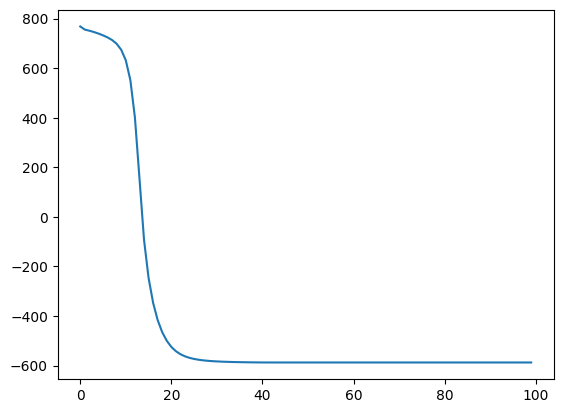

In [12]:
plt.plot(data["obj_vals"])
plt.show()

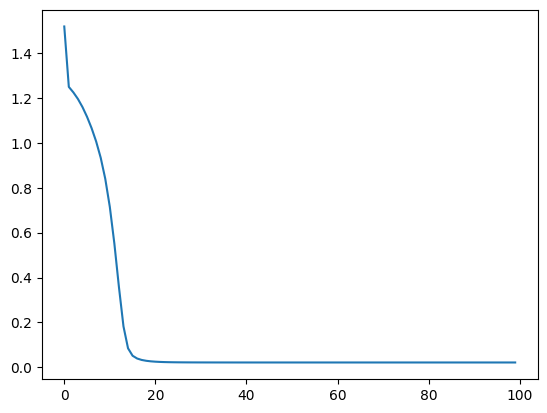

In [13]:
plt.plot(data["noise_vars"])
plt.show()

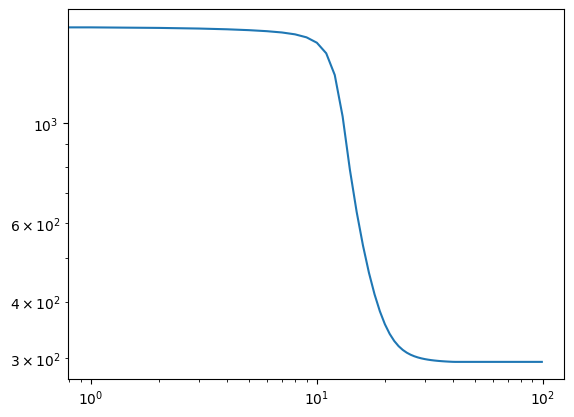

In [14]:
plt.loglog(data["obj_vals"] - 1.5*np.amin(data["obj_vals"]))
plt.show()

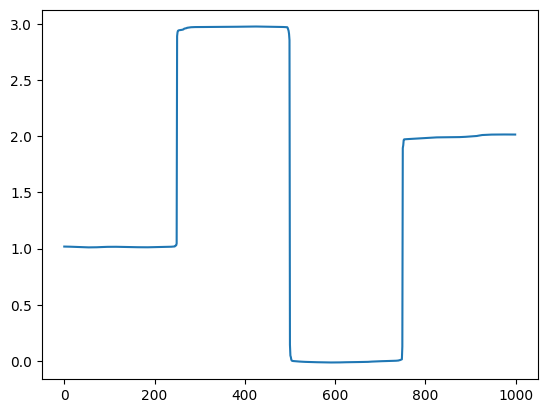

In [15]:
plt.plot(data["x"])
plt.show()

In [16]:
data["noise_var"]

0.021752493401753243

In [17]:
noise_var

0.0225

# Transformed sampling

In [18]:
tsampler = sampi.PriorconditionedIASGaussianSampler(F, R, noisy_signal, data["theta"], pdata=pdata, noise_var=data["noise_var"])

In [32]:
tsdata = tsampler.sample(n_samples=1000, priorconditioning=True, warmstarting=True, tol=1e-1)

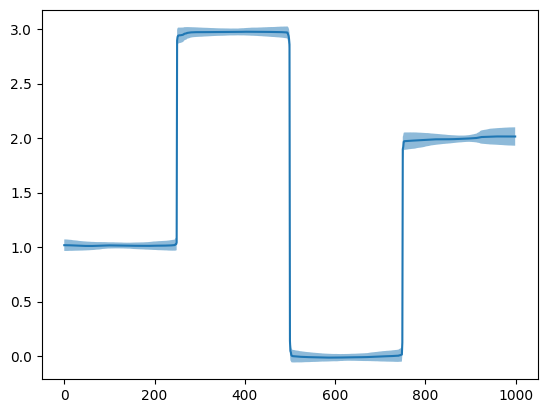

In [33]:
plt.plot(grid, tsdata["mean"])
sigmas = tsdata["stdev"]
plt.fill_between(grid, tsdata["mean"] - 3*sigmas, tsdata["mean"] + 3*sigmas, alpha=0.5)
plt.show()

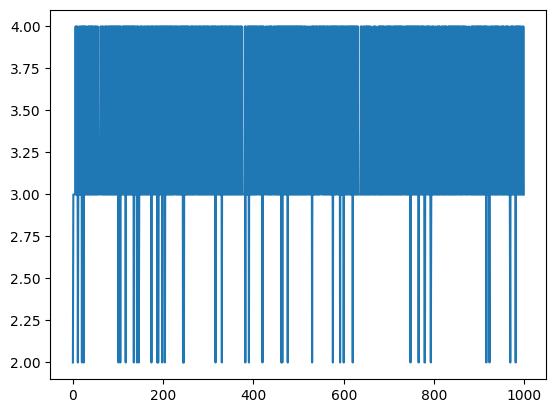

In [34]:
plt.plot(tsdata["n_cg_its_per_sample"])
plt.show()

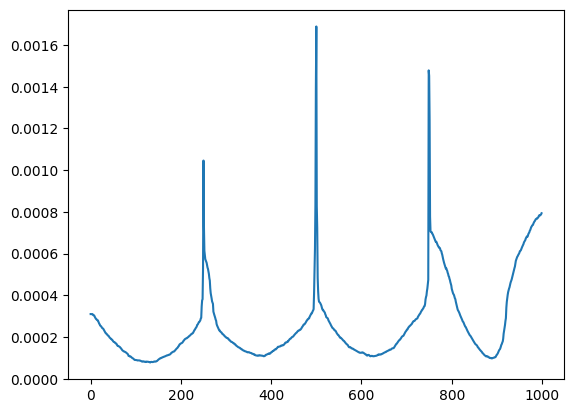

In [35]:
plt.plot(tsdata["var"])
plt.show()

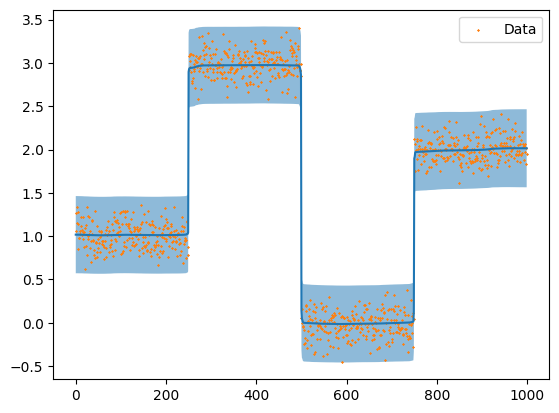

In [36]:
plt.plot(grid, tsdata["mean"])
marg_vars = tsdata["var"] + data["noise_var"]
sigmas = np.sqrt(marg_vars)
plt.fill_between(grid, tsdata["mean"] - 3*sigmas, tsdata["mean"] + 3*sigmas, alpha=0.5)
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.legend()
plt.show()

# Sample the posterior (condition on fixed hyperparameters)

In [54]:
# Build sampler
map_noise_var = data["noise_var"]
map_theta = data["theta"]
Ftilde = (1.0/np.sqrt(map_noise_var))*F
ytilde = (1.0/np.sqrt(map_noise_var))*noisy_signal
Rtilde = jlinops.DiagonalOperator(1.0/np.sqrt(map_theta)) @ R

factors = [Ftilde, Rtilde]
shifts = [ytilde, None]

In [55]:
sampler = sampi.CGLSGaussianSampler(factors, shifts)

In [56]:
sdata = sampler.sample(n_samples=100, warmstarting=True, tol=1e-7)

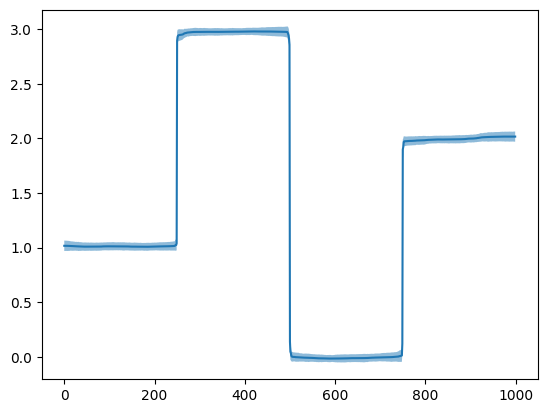

In [57]:
plt.plot(grid, sdata["mean"])
sigmas = sdata["stdev"]
plt.fill_between(grid, sdata["mean"] - 3*sigmas, sdata["mean"] + 3*sigmas, alpha=0.5)
plt.show()

In [58]:
sdata.keys()

dict_keys(['mean', 'stdev', 'var', 'n_cg_its_per_sample', 'tracker', 'obs_trackers'])

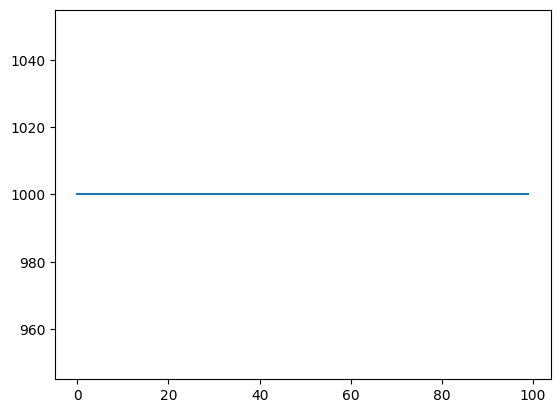

In [59]:
plt.plot(sdata["n_cg_its_per_sample"])
plt.show()

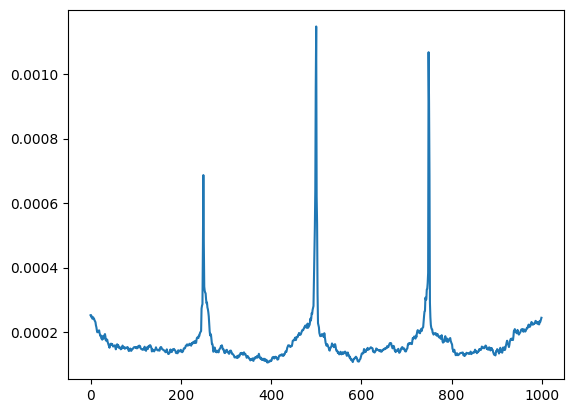

In [60]:
plt.plot(sdata["var"])
plt.show()

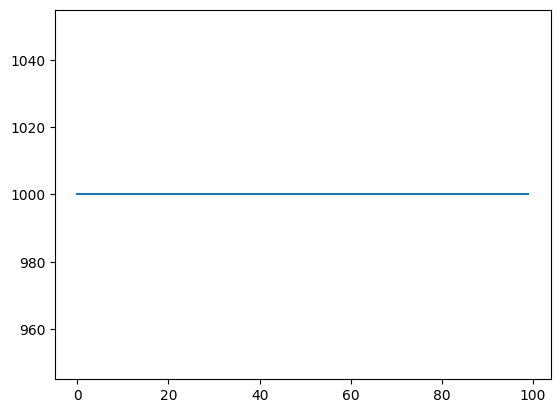

In [61]:
plt.plot(sdata["n_cg_its_per_sample"])
plt.show()

# Sample posterior predictive

In [23]:
post_pred_func = lambda z: z + np.sqrt(map_noise_var)*np.random.normal(size=z.shape)
#post_pred_func = lambda z: np.ones_like(z)

In [24]:
sampler = sampi.CGLSGaussianSampler(factors, shifts)

In [25]:
sdata = sampler.sample(n_samples=100, warmstarting=False, observables=[post_pred_func])

In [26]:
np.linalg.norm(sdata["tracker"].mean() - sdata["obs_trackers"][0].mean())

0.0

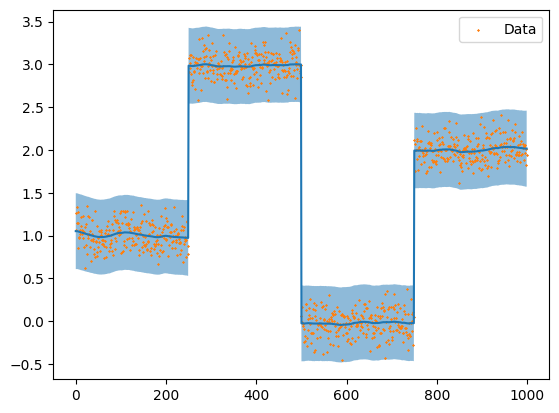

In [36]:
plt.plot(grid, sdata["mean"])
marg_vars = sdata["var"] + map_noise_var
sigmas = np.sqrt(marg_vars)
plt.fill_between(grid, sdata["mean"] - 3*sigmas, sdata["mean"] + 3*sigmas, alpha=0.5)
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.legend()
plt.show()

# Compare to LASSO?

In [18]:
lasso_sampler = sampi.BayesianLASSOGibbsSampler(F, R, noisy_signal, noise_var=noise_var, reg_lambda=reg_lambda)

In [19]:
lasso_result = lasso_sampler.sample(n_samples=1000, n_burn=500)

AttributeError: 'IdentityOperator' object has no attribute 'A'